# Multiclass Image Classification with Transfer Learning

The following project implements a multi-class classification NN for chest x-rays, and applies transfer learning by initializing the model with the Inception V3 architecture and 'imagenet' weights (i.e. weights for that architecture trained on the ImageNet dataset). The chest X-rays dataset is taken from: https://openaccess.thecvf.com/content_cvpr_2017/papers/Wang_ChestX-ray8_Hospital-Scale_Chest_CVPR_2017_paper.pdf

In [2]:
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image

## Data preparation

### Labels


In [37]:
df = pd.read_csv(('medical-ai/labels.csv'))

print("Possible labels:",df.label.unique())
df

Possible labels: ['Atelectasis' 'Cardiomegaly' 'Effusion' 'Infiltrate' 'Mass' 'Nodule'
 'Pneumonia' 'Pneumothorax' 'No Finding']


,filename,height,width,label,xmin,ymin,xmax,ymax,view
0,00013118_008.jpg,2992,2991,Atelectasis,225.0,547.0,311.0,626.0,PA
1,00014716_007.jpg,3056,2544,Atelectasis,686.0,131.0,871.0,444.0,AP
2,00029817_009.jpg,3056,2544,Atelectasis,221.0,317.0,376.0,533.0,AP
3,00014687_001.jpg,2500,2048,Atelectasis,726.0,494.0,867.0,549.0,AP
4,00017877_001.jpg,2500,2048,Atelectasis,660.0,569.0,860.0,647.0,AP
...,...,...,...,...,...,...,...,...,...
1959,00000506_028.jpg,2500,2048,No Finding,NaN,NaN,NaN,NaN,AP
1960,00000506_029.jpg,2500,2048,No Finding,NaN,NaN,NaN,NaN,AP
1961,00000506_030.jpg,2500,2048,No Finding,NaN,NaN,NaN,NaN,AP
1962,00000507_000.jpg,2766,2801,No Finding,NaN,NaN,NaN,NaN,PA


In [38]:
unique_labels = df['label'].unique()

# Create a mapping from labels to integer indices
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}

# Convert the labels in the dataframe to their corresponding integer indices
df['label_index'] = df['label'].map(label_to_index)

# One-hot encode the label indices using TensorFlow's one_hot method
one_hot_labels = tf.one_hot(indices=df['label_index'], depth=len(unique_labels))

one_hot_labels.shape

TensorShape([1964, 9])

### Images

In [39]:
images = []

for filename in df['filename']:

    # Take into account the right path
    image_path = "medical-ai/images/" + filename

    # Load the image, resize it, convert to RGB
    image = Image.open(image_path).resize(size=(256, 256)).convert(mode='RGB')

    # Create a NumPy array from the image and append it to list
    images.append(np.array(image))

images = tf.convert_to_tensor(images)

images.shape

TensorShape([1964, 256, 256, 3])

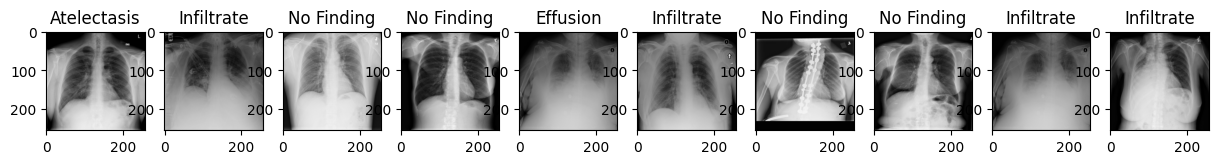

In [40]:
# Plot 10 random images from the dataset and their labels
fig, subplots = plt.subplots(1, 10, figsize=(15, 15))
for plot_index,data_index in enumerate(random.randint(0, 1963) for _ in range(10)):
    subplots[plot_index].set_title(df.loc[data_index,'label'])
    subplots[plot_index].imshow(images[data_index])

## Model definition

In [55]:
# Create an instance of a pre-trained model
pre_trained_model = tf.keras.applications.inception_v3.InceptionV3(
    input_shape=(256, 256, 3),
    weights='imagenet',
    include_top=False
)

# Freeze the weights in the layers of the pre-trained model
for layer in pre_trained_model.layers:
    layer.trainable = False

# Add custom layers to the pre-trained model
last_layer = pre_trained_model.output
# Add a Global Average Pooling 2D layer
last_layer = tf.keras.layers.GlobalAveragePooling2D()(last_layer)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
last_layer = tf.keras.layers.Dense(units=1024, activation='relu')(last_layer)
# Add a final layer with softmax activation (for multi-class classification), with as many neurons as labels in our data
last_layer = tf.keras.layers.Dense(units=one_hot_labels.shape[1], activation='softmax')(last_layer)

# Define the new model, compile it, and fit it to our dataset
model = tf.keras.Model(inputs=pre_trained_model.input, outputs=last_layer)
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall()
    ]
)

## Model training

In [56]:
history = model.fit(
    x=images,
    y=one_hot_labels,
    validation_split=0.2,   # Fraction of the data to use as validation
    shuffle=True,           # Shuffles data before each epoch
    epochs=10,
    batch_size=128
)

Epoch 1/10
13/13 [==============================] - 118s 9s/step - loss: 73.8794 - accuracy: 0.1948 - auc: 0.5512 - precision: 0.1950 - recall: 0.1948 - val_loss: 3.8883 - val_accuracy: 0.7176 - val_auc: 0.8631 - val_precision: 0.7168 - val_recall: 0.7150
Epoch 2/10
13/13 [==============================] - 117s 9s/step - loss: 25.7568 - accuracy: 0.2756 - auc: 0.6204 - precision: 0.2760 - recall: 0.2718 - val_loss: 12.1913 - val_accuracy: 0.0662 - val_auc: 0.5390 - val_precision: 0.0660 - val_recall: 0.0636
Epoch 3/10
13/13 [==============================] - 121s 9s/step - loss: 11.8069 - accuracy: 0.2406 - auc: 0.6133 - precision: 0.2497 - recall: 0.2374 - val_loss: 3.4387 - val_accuracy: 0.3333 - val_auc: 0.7453 - val_precision: 0.3389 - val_recall: 0.3079
Epoch 4/10
13/13 [==============================] - 127s 10s/step - loss: 5.5330 - accuracy: 0.2826 - auc: 0.6561 - precision: 0.2945 - recall: 0.2603 - val_loss: 2.1791 - val_accuracy: 0.4631 - val_auc: 0.8242 - val_precision: 0.4

## Results

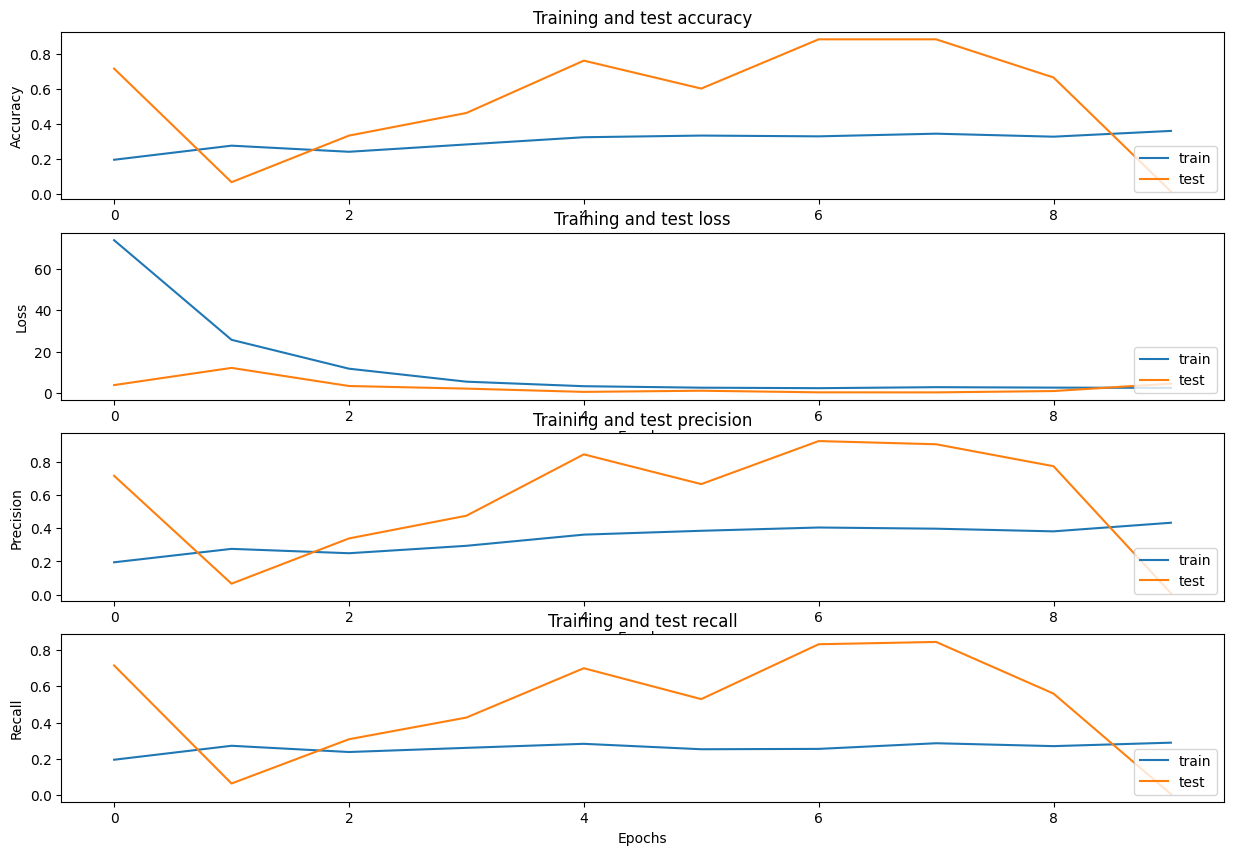

In [69]:
# Get number of epochs
epochs = range(len(history.history['accuracy']))
plt.figure(figsize=(15,10))

plt.subplot(4,1,1)
plt.plot(epochs, history.history['accuracy'], label="train")
plt.plot(epochs, history.history['val_accuracy'], label="test")
plt.ylabel("Accuracy")
plt.title('Training and test accuracy')
plt.legend(loc="lower right")

plt.subplot(4,1,2)
plt.plot(epochs, history.history['loss'], label="train")
plt.plot(epochs, history.history['val_loss'], label="test")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Training and test loss')
plt.legend(loc="lower right")

plt.subplot(4,1,3)
plt.plot(epochs, history.history['precision'], label="train")
plt.plot(epochs, history.history['val_precision'], label="test")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.title('Training and test precision')
plt.legend(loc="lower right")

plt.subplot(4,1,4)
plt.plot(epochs, history.history['recall'], label="train")
plt.plot(epochs, history.history['val_recall'], label="test")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.title('Training and test recall')
plt.legend(loc="lower right")

plt.show()

## Next steps (not implemented)

Possible ways to continue improving model performance:
- Data augmentation
- A different NN architecture
- Allow training some of the pre-trained weights
- More training epochs
- Hyperparameter tuning